# Given a CSV, detect the bank it came from
This uses "`Dataset.csv`" prepared in Step 01, and constructs a classifier which when given a statement description, detects the bank it came from.

## All python imports and globals

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import modelutils as mu



DATASET_FILE='../data/Dataset.csv'

COL_NAME_DATE='Date'
COL_NAME_AMOUNT='Amount'
COL_NAME_DESC='Description'
COL_NAME_BANK='Bank'

CSV_TYPE_CBA='CBA'
CSV_TYPE_BENDIGO='BENDIGO'
CSV_TYPE_ANZ='ANZ'
CSV_TYPE_UNKNOWN='UNKNOWN'


## Read dataset and vectorize
Load the CSV, and encode the String labels for "Bank" (output) to number

In [2]:
rawdf = pd.read_csv(DATASET_FILE)
bankLabelEncoder = preprocessing.LabelEncoder()
rawdf['EncodedBankLabels'] = bankLabelEncoder.fit_transform(rawdf['Bank'])
print rawdf.head(10)
print "Labels: ", bankLabelEncoder.classes_


         Date  Amount                                        Description  \
0  18/06/2017   -16.4  RETAIL PURCHASE WOLESLEY MGT PTY LTD, ULTIMO 1...   
1    3/8/2017  -12.50  LEFT BOWER CAFE SUTHERLAND NS AUS Card xx7113 ...   
2  27/09/2016    -0.3                      INTERNATIONAL TRANSACTION FEE   
3  03/05/2016  -14.99  RETAIL PURCHASE-INTERNATIONAL ADOBE CREATIVE C...   
4  05/01/2016   302.0       E-BANKING TRANSFER 0097574257 00247011611301   
5  04/11/2016   -36.0  RETAIL PURCHASE GLEBE FAMILY MEDICAL, GLEBE 02...   
6  26/05/2017   -4.00  SQ *WHITE HORSE COFFEE Sutherland NS AUS Card ...   
7  02/08/2017  -242.0  RETAIL PURCHASE EVERTEC PTY LTD, LIDCOMBE 0108...   
8  22/01/2017   -51.0  RETAIL PURCHASE Soul Burger - Glebe, Glebe 210...   
9  28/05/2017   -87.5  RETAIL PURCHASE IAN THORPE AQUATIC, ULTIMO 260...   

      Bank  EncodedBankLabels  
0  BENDIGO                  1  
1      CBA                  2  
2  BENDIGO                  1  
3  BENDIGO                  1  
4  

## Vectorize Description column

In [3]:
vectorizer = CountVectorizer()
descriptions = vectorizer.fit_transform(rawdf['Description']).todense()

print descriptions

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [4]:
# the vectorizer can now be used to transform unseen text
vectorizer.transform(["new text"])

<1x3903 sparse matrix of type '<type 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

## Split dataset into train and test


In [5]:
x_train, x_test, y_train, y_test = train_test_split(descriptions,
                                                    rawdf['EncodedBankLabels'].as_matrix())

print "Sample split: \n", x_train[:10],"\n", y_train[:10]

Sample split: 
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]] 
[1 1 1 1 1 0 1 2 1 2]


### Build Classifier

In [6]:
clf =  GaussianNB()
fitted = clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, cv=5)
print "Mean score: ", np.mean(scores), "\n", scores

Mean score:  0.98797478434 
[ 0.99090909  0.98363636  0.98905109  0.98722628  0.98905109]


## Show confusion matrix

In [7]:
def displayConfusionMatrix(cmatrix):
    print cmatrix
    plt.matshow(cmatrix)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[ 25   6   0]
 [  0 747   0]
 [  0   0 137]]


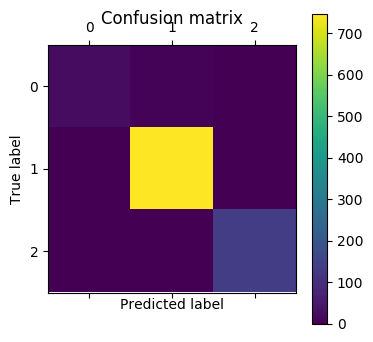

In [8]:
y_pred = clf.predict(x_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
displayConfusionMatrix(confusion_matrix)




The confusion matrix above shows that Bendigo and CBA can be accurately predicated (all true positives only), but ANZ can occassionally be classified incorrectly

### Trying out a few samples manually

In [9]:
testTexts = [
    "SandwichesForSydneyML NORTH RYDE 3103 AUD000000005999",
    "Some random merchant sydney Card xx1234 gibberish",
    "Pay TPG internet Sydney",
            ]
vector = vectorizer.transform(testTexts).todense()
print clf.predict_proba(vector)
print bankLabelEncoder.classes_[(clf.predict(vector))]

[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]]
['BENDIGO' 'CBA' 'ANZ']


## Save (pickle) the necessary components to re-use the classifier
We will need to save both `vectorizer`, `bankLabelEncoder` and `clf`, since both will be required to classify unseen text, as seen in the example above, by using the same vectorizer to encode the input text to be fed into the classifier, and to interpret the output labels correctly

In [10]:
mu.saveBankDetectorModels(classifier=clf,vectorizer=vectorizer,labelEncoder=bankLabelEncoder)

(True,
 'Persisted files:  models/bank_detector_clf.pkl,   models/bank_detector_vectorizer.pkl, and   models/bank_detector_labelEncoder.pkl')